In [0]:
import math
import pandas as pd
import numpy as np
import calendar
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime

from matplotlib.dates import DateFormatter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, mutual_info_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

# Download the Data 
Keep this if you are working in Google Colab. Delete this if you are working on your own computer and have the data downloaded already. 

In [26]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3' -O lendingclub.csv

--2020-02-03 02:47:00--  https://docs.google.com/uc?export=download&id=0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3
Resolving docs.google.com (docs.google.com)... 108.177.127.101, 108.177.127.113, 108.177.127.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hq3u6n9nrm0du8j10i684rqq6mvm3bh2/1580695200000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download [following]
--2020-02-03 02:47:01--  https://doc-10-5c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hq3u6n9nrm0du8j10i684rqq6mvm3bh2/1580695200000/09819396713149841370/*/0B5qTk6DHjanhOV9LRE5DY3l1T2pGemVBNTVQVzVsMlFCcHF3?e=download
Resolving doc-10-5c-docs.googleusercontent.com (doc-10-5c-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting

# Introduction to homework 1
On Canvas (or in this notebook's files) you’ll find a new file, **lendingclub.csv**. The file contains 81,105 rows and each row of this file represents a single user
account on **LendingClub.com**. The site consists of two types of users, **borrowers** who are applying for a new loan, and **investors** who lend money for fixed periods of time. Each row in our dataset represents a single borrower at the time they apply for their first peer-to-peer loan, and each row contains nine columns:

- **amount**: Amount requested for their first loan
- **date**: Year the loan was requested (this dataset covers only a five-year period, 2008-2012)
- **title**: Title of the loan application (written by the borrower)
- **fico**: FICO score (credit rating) of the borrower
- **dti**: “Debt-to-Income”: A ratio of the borrower’s total monthly debt payments, excluding home
mortgage and the requested loan, to the borrower’s self-reported monthly income.
- **zip**: ZIP code of the borrower (the last two digits of each ZIP are masked for anonymity)
- **state**: U.S. state that the borrower resides in
- **emp_length**: Length of time that the borrower has been employed at their current job, from 0 to 10+ years
- **outcome**: A binary outcome variable for whether the user’s loan application was accepted by investors

Cleaned data includes 11 columns. Additional two columns transform **outcome** (accept/reject) into **policy of code** (1.0/0.0) and extract **year of lending** from **date**.

Our goal with this project will be to automatically predict whether a borrower will be approved for a loan from the investor members of the website, based only on the data provided above. For each of the following questions, add a series of code and markdown cells to develop an easily readable report responding to the question. 

In [27]:
LC = pd.read_csv("lendingclub.csv") 
LC.head()

,amount,date,title,fico,dti,zip,state,emp_length,policy_code,year,outcome
0,2500.0,Dec-2011,bike,740.0,1.00,309xx,GA,< 1 year,1.0,2011,accept
1,12000.0,Dec-2011,Consolidation,675.0,10.78,913xx,CA,10+ years,1.0,2011,accept
2,21000.0,Dec-2011,Debt Cleanup,705.0,13.22,335xx,FL,10+ years,1.0,2011,accept
3,31825.0,Dec-2011,Debt Consolidation Loan,760.0,14.03,080xx,NJ,5 years,1.0,2011,accept
4,12000.0,Dec-2011,Debt Consolidation,725.0,16.70,088xx,NJ,10+ years,1.0,2011,accept


# Question 1:
- Why is this data about users valuable to LendingClub?
- Name at least two different ways this automated prediction could be used either for in-app product changes, or business decision-making.

## Importance to LendingClub

Lenders provide loans in exchange for the promise of repayment with interest from borrowers. Given that said, a lender always asks two ultimate questions: 
1. How risky is the borrower?
2. Given that risk, should I lend him/her? 

The goal of this prediction is to provide answers to the questions above. Using the historical data from loans that were issued on LendingClub between 2008 and 2012, we can even analyze `how the average returns of investor increase from such informed prediction in the context of peer-to-peer loan investments` after we know additional data such as **annual interest rate** and **lending periods**.

## Benefits of Prediction

Before answering the question, I performed a company research. Founded in 2007,  San Francisco-based [LendingClub](https://www.lendingclub.com/) solved the pain point as one of the leading FinTech unicorns, which enables consumers and small business owners lower the cost of their credit and enjoy a better experience than traditional bank lending, and investors earn attractive risk-adjusted returns.

The online platform has two primary business segments. The company not only allows its clients to borrow, but also provides an avenue for its other clients to invest in the loans being provided. Below are a simplified process how clients can borrow a loan:
1. Clients interested in a loan complete a simple online application
2. LendingClub leverages online data and technology to quickly assess risk, determines a credit rating, and assigns appropriate interest rates
3. Qualified applicants receive offers in just minutes and can evaluate loan options with no impact to their credit score
4. Investors ranging from individuals to institutions procure notes which match up to fractions of loans and select loans in which to invest in a hope of earning monthly returns

This automated prediction can help this FinTech unicorn to confront both from the financial and legal doomsay. On the one hand, both [The Wall Street Journal](https://www.wsj.com/articles/cashing-in-on-fintech-unicorns-is-harder-than-it-seems-11576533185) and [The Economist](https://www.economist.com/finance-and-economics/2019/12/05/created-to-democratise-credit-p2p-lenders-are-going-after-big-money) expressed the high cost of acquiring customers and the hardiness to cash in. A predictive **product feature** can be `added to investors to favor borrowers with high internal grades` like [Bloomgberg](https://www.bloomberg.com/news/articles/2019-12-16/fintech-lenders-tighten-standards-as-they-become-more-like-banks) mentioned in December, 2019.

On the other hand, LendingClub exist somewhere outside the regulatory perimeter beacuse the Trump administration have trotted out a fintech banking charter and strips state oversight. [LexisNexis](https://www.law.com/delbizcourt/2019/12/11/what-is-oversight-del-courts-continue-to-provide-clarification-post-marchand/?slreturn=20200102024737) pointed that Deleware court dismissed allegations that the board of directors of LendingClub engage in deceptive or discriminatory lending, while [Federal Trade Commission (FTC)](https://www.ftc.gov/news-events/press-releases/2018/11/ftc-amends-complaint-against-lending-club) have amended its complaint against the company. [LendingClub](https://blog.lendingclub.com/lendingclub-responds-to-federal-trade-commission-complaint/)  currently holds a tough tone to claim that "the allegations in the FTC’s complaint are legally and factually unwarranted." However, a **strategic direction** I would suggest is to `select credible clients based on prediction and prepare for rules to protect those clients` to avoid future escalated ligitation.

To sum up, this prediction might be useful for a scenario like, "investors would like to send money to borrowers with high credibility to get high returns." Therefore, two ways of benefits include:
- Is the borrower credible?
- Are the investors going to make money by that?


# Question 2: 
Train a decision tree classifier to predict loan acceptance based on the features provided. You should NOT perform any optimization; all you need to do is train a single decision tree and report results. You will be tuning hyperparameters and performing other evaluations in Homework 2.

Write a report giving at minimum the following information on your model:
- Class distribution of the outcome labels.
- List of features you used from the data, including their name and data type (numeric or
nominal). For each feature, provide min, mean, and max values (if the feature is numeric) or
list all possible labels (if the feature is nominal).
- Performance of the trained classifier, using metrics like accuracy, kappa, precision, and recall. You must provide a labeled confusion matrix.
- List of hyperparameter settings for the decision tree.

## Identify Pre-requisites
First, I walk-throughed my thinking project goals as the following:

1. Dataset: 5-year data includes 81k+ total rows and each row represents one lending record; 

2. Task: Predict if a borrower will be accepted or rejected by the investors; 

3. Class: binary **outcome** labels (accpet/reject)

4. Numeric features: **amount**, **fico**, **dti**; nominal feature: **emp_length**

Then, I evaluated when each feature represents meaningful:

1. Balance Amount along with Employment Length are actually the features with the least obvious link to acceptance rate.

2. FICO score was relied heavily on. On [the company website](https://www.lendingclub.com/loans/resource-center/understanding-credit-scores), "the median FICO credit score range is 670 to 739, scores from 740 to 799 are considered very good, and anything above 800 is exceptional."

3. The DTI ratio: the lower the better. A DTI of 5 means your debts payment are only 5% of your gross income. [The company](https://blog.lendingclub.com/responsible-lending-better-returns/) said "borrowers with loan requests on the site enjoy an average FICO score of about 700 and a 12% debt-to-income (DTI) ratio, excluding mortgage. Lending Club maintains very high standards to list a loan, with a minimum FICO of 640 and a maximum DTI of 30% required."

In [28]:
LC_features = LC.loc[:,["amount","fico","dti","emp_length"]]
LC_features.describe()

,amount,fico,dti
count,81103.000000,81103.000000,8.110300e+04
mean,12959.437855,603.010961,5.142695e+02
std,10315.880464,173.772811,1.700466e+04
min,500.000000,0.000000,-1.000000e+00
25%,5000.000000,585.000000,6.530000e+00
50%,10000.000000,653.000000,1.648000e+01
75%,20000.000000,691.000000,2.888000e+01
max,500000.000000,850.000000,3.418800e+06


In [29]:
LC_features.emp_length.unique()

array(['< 1 year', '10+ years', '5 years', '9 years', '6 years',
       '2 years', '3 years', '7 years', '8 years', '4 years', '1 year'],
      dtype=object)

## Creating the Train/Test Split

Now that we know that using a train/test split is important for properly evaluating our models, let's consider some different ways to potentially create that train/test split. We'll see that we have to be careful when creating our train/test split to make sure that it makes sense. 

In [45]:
# Calculate how often to send data to the test set (in our case for an 80/20 train/test split)
test_size = 0.2
test_modulus = int(1/test_size)

# Set 4/5 data points from each set of 5 data points to be in the train set
LC_train = LC.iloc[LC.index % test_modulus != 0]
# Set the remaining 1 data point from each set of 5 data points to be in the test set
LC_test = LC.iloc[LC.index % test_modulus == 0]

# Lets confirm the size of the train and test set are still about right
print("Size of train data:", len(LC_train))
print("Size of test  data:", len(LC_test))

# Lets examine the distribution of the months in the two datasets
print("Training set months:")
print(LC_train["year"].value_counts())
print("Test set months:")
print(LC_test["year"].value_counts())

Size of train data: 64882
Size of test  data: 16221
Training set months:
2012    30504
2011    18725
2010     9132
2009     4491
2008     2030
Name: year, dtype: int64
Test set months:
2012    7625
2011    4682
2010    2283
2009    1123
2008     508
Name: year, dtype: int64


In [46]:
numeric_features = ["amount","fico","dti"]
nominal_features = ["emp_length"]

feature_set = numeric_features + nominal_features

X = LC.loc[:, feature_set]
X = pd.get_dummies(X)

y = LC["outcome"]

# Use scikit-learn to create our train/test split and train our decision tree
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(64882, 14)
(16221, 14)
(64882,)
(16221,)


## Comparing training-set results to test-set results

Lets see how we can use the train/test split we created to better understand and compare different models. 

In [48]:
# Create lists of possible features (Same as in Day 1)
numeric_features = ["amount","fico","dti"]
nominal_features = ["emp_length"]

feature_set = numeric_features + nominal_features

feature_sets = {
    "numeric": numeric_features,
    "nominal": nominal_features,
    "all": numeric_features + nominal_features
}

# We'll keep track of which classifier was the best
best = 0
best_name = None
best_actual = None
best_predictions = None

test_accuracies = []
train_accuracies = []

# For each feature set, we evaluate our model on both the train and the test set
for set_name, feature_set in feature_sets.items():

    # Create a dummyset with only the features in our feature set
    X = LC.loc[:, feature_set]
    X = pd.get_dummies(X)

    y = LC["outcome"]

    # Use scikit-learn to create our train/test split and train our decision tree
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=123)
    model = DecisionTreeClassifier(criterion="entropy", random_state=123).fit(X_train, y_train)

    # Calculate our accuracy on the train and test sets
    train_pred = model.predict(X_train)
    train_accuracy = 100*accuracy_score(y_train, train_pred)
    
    test_pred = model.predict(X_test)
    test_accuracy = 100*accuracy_score(y_test, test_pred)

    # Keep track of the best model on the test set
    if test_accuracy > best:
        best = test_accuracy
        best_name = set_name
        best_actual = y_test
        best_predictions = test_pred
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

    # Display the accuracy on the train and test set for each model
    print(f"Results for {set_name}:")
    print(f"Accuracy on the train set: {train_accuracy:.1f}")
    print(f"Accuracy on the test set: {test_accuracy:.1f}")
    print("------------------------")
    
print(f"Best feature set is: {best_name} \nWith: {best:.1f}% accuracy.")  

Results for numeric:
Accuracy on the train set: 100.0
Accuracy on the test set: 93.8
------------------------
Results for nominal:
Accuracy on the train set: 88.6
Accuracy on the test set: 88.5
------------------------
Results for all:
Accuracy on the train set: 100.0
Accuracy on the test set: 94.9
------------------------
Best feature set is: all 
With: 94.9% accuracy.


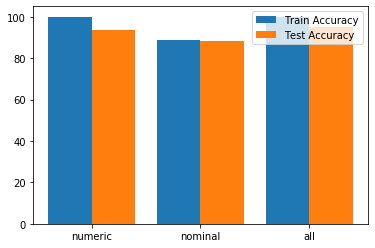

In [49]:
locs = np.arange(len(test_accuracies))

ax = plt.gca()
ax.bar(locs-0.2, train_accuracies, width=0.4)
ax.bar(locs+0.2, test_accuracies, width=0.4)
ax.set_xticks(locs)
ax.set_xticklabels(list(feature_sets.keys()))
ax.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

## Metrics of Model Quality

While accuracy is great some of the time, there are many cases where it is not a good metric for understanding the performance of our models. Lets explore some alternate methods for evaluating our models and figure out when we should be using them. 

In [0]:
# Lets keep the predictions from the best tree that we found to use in this section
predictions = best_predictions
actual = np.array(list(best_actual))

### Accuracy

$$ accuracy = \frac{correct \space predictions}{total \space predictions} \times 100 $$

In [52]:
# Calculating accuracy with scikit-learn
accuracy = accuracy_score(actual, predictions)
print(f"scikit-learn accuracy metric: {100*accuracy:.1f}")

scikit-learn accuracy metric: 94.9


### Confusion Matrix

The confusion matrix is a great way to visualize where our model is making errors. Elements on the diagonal represent correct predictions. Elements off the diagonal represent that the model predicted the wrong class.

In [53]:
# Generating our confusion matrix manually

# Helper function to display our confusion matrix nicely
def matrix_print(matrix):
    print("           Predictions")
    print(f"Actual    |", end='')
    for pred in list(matrix.keys()):
        print(f"{str(pred).rjust(10)}|", end='')
    print()
    for act in list(matrix.keys()):
        print(f"{str(act).rjust(10)}|", end='')
        for pred in list(matrix.keys()):
            cell = matrix[pred][act]
            print(f"{str(cell).rjust(10)}|", end='')
        print()

# Actually computing our confusion matrix         
def build_confusion_matrix(actual, predictions):
    confusion_matrix = {}
    for pred_value in np.unique(predictions):
        confusion_matrix[pred_value] = {}
        for act_value in np.unique(actual):
            cell_count = 0
            for i in range(len(actual)):
                if predictions[i] == pred_value and actual[i] == act_value:
                    cell_count += 1
            confusion_matrix[pred_value][act_value] = cell_count
    return confusion_matrix

conf_matrix = build_confusion_matrix(actual, predictions)
matrix_print(conf_matrix)

           Predictions
Actual    |    accept|    reject|
    accept|      1444|       428|
    reject|       401|     13948|


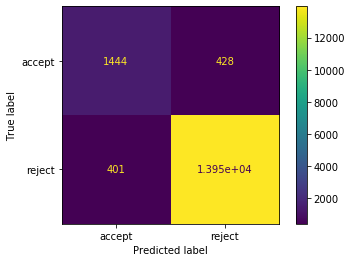

In [55]:
# Generating our confusion matrix with scikit-learn
conf_matrix = confusion_matrix(actual, predictions)
ConfusionMatrixDisplay(conf_matrix, ["accept", "reject"]).plot(values_format='.4g')
plt.show()

### Cohen's Kappa

$$ \kappa = \frac{accuracy - chance \space agreement}{1 - chance \space agreement}$$


In [56]:
# Calculating Kappa with scikit-learn
kappa = cohen_kappa_score(actual, predictions)
print(f"scikit-learn kappa metric: {kappa:.3f}")

scikit-learn kappa metric: 0.748


### Precision and Recall

$$ Precision = \frac{sucessful \space predictions}{predicted \space positives}$$
$$ Recall = \frac{sucessful \space predictions}{actual \space positives}$$

In [65]:
# Compute Precision and Recall with a Confusion Matrix
conf_matrix = build_confusion_matrix(actual, predictions)

successful_positives = conf_matrix["accept"]["accept"]
predicted_positives = 0
for a in conf_matrix["accept"].keys():
    predicted_positives += conf_matrix["accept"][a]

precision = successful_positives / predicted_positives
print(f"Precision: {precision:.3f}")

actual_positives = 0
for p in conf_matrix.keys():
    actual_positives += conf_matrix[p]["accept"]
    
recall = successful_positives / actual_positives
print(f"Recall: {recall:.3f}")

Precision: 0.783
Recall: 0.771


# Question 3: 

Is the decision tree that you trained accurate enough to be used for each of the two business purposes you proposed in question 1? Why or why not?

First, we can tell from Question 2's Identify Pre-requisites Answers:
1. Borrowers' FICO scores are, on average, lower than the median FICO score
2. But their DTI ratios are lower and better than what the FICO scores represent

Second, after comparing trained and test dataset, we can tell that while 94.9% accuracy is pretty great, that 5% of misclassified data demonstrates that our model is definitely not perfect. We can also see that the model trained on just all is actually better than the model trained on just numeric features! This is an example of more data having more information gain and being better and an example of how our decision tree algorithm does cover to the optimal tree.

Thrid, the metric quality shows:
- 94.9% scikit-learn accuracy metric and 0.748 kappa metric
- 1,444 true positive, 428 false positive, 401 false negative, and 13,948 true negative
- 0.783 precision and 0.771 recall

We can tell that higher accuracy does not always result in a higher kappa. Excluding the consideration of how lopsided my data is, 0.748 is common thresholds for “good”, which tells us semi-answer to the first question: `the majority of borrowers in this dataset are credible`. 

Precision tells me that a classification model can actually identify 78.3% relevant data points in prediction, which answered more specifictly about my first question: `investors will 78.3% find the credible borrowers accurately`. And recall number tells me that this model can actually find 77.1% relevant cases within a dataset, which means `77.1% investors make money to invest`.

# Scoring Rubric
![alt text](https://docs.google.com/uc?export=view&id=1ELG4QWnPjWgiUJI0eL6YiVbMWKlSVdcP)
